<a href="https://colab.research.google.com/github/venetisgr/car_brand_identification/blob/main/vit_hf_wand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Library Load

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/Deep_Learning_GATECH/proj
# print()
# !ls

In [ ]:
!pip install transformers -q
#!pip install -q git+https://github.com/huggingface/transformers.git

     |████████████████████████████████| 5.5 MB 4.8 MB/s 
     |████████████████████████████████| 7.6 MB 76.2 MB/s 
     |████████████████████████████████| 182 kB 75.8 MB/s 


In [ ]:
!pip install datasets[vision] -q

     |████████████████████████████████| 451 kB 4.8 MB/s 
     |████████████████████████████████| 212 kB 87.9 MB/s 
     |████████████████████████████████| 115 kB 85.7 MB/s 
     |████████████████████████████████| 127 kB 83.1 MB/s 


In [ ]:
from transformers import ViTForImageClassification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torchvision.transforms import RandAugment, ToTensor
from transformers import ViTFeatureExtractor,TrainingArguments, Trainer
from datasets import load_dataset, load_metric

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from datasets import DatasetDict

In [ ]:
#!pip install datasets -q
# !pip install datasets[vision] -q

In [ ]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image


In [ ]:
!pip install wandb -q

     |████████████████████████████████| 1.9 MB 4.7 MB/s 
     |████████████████████████████████| 168 kB 72.5 MB/s 
     |████████████████████████████████| 182 kB 67.5 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 168 kB 67.7 MB/s 
     |████████████████████████████████| 166 kB 67.5 MB/s 
     |████████████████████████████████| 166 kB 66.9 MB/s 
     |████████████████████████████████| 162 kB 68.6 MB/s 
     |████████████████████████████████| 162 kB 86.3 MB/s 
     |████████████████████████████████| 158 kB 54.6 MB/s 
     |████████████████████████████████| 157 kB 55.0 MB/s 
     |████████████████████████████████| 157 kB 55.2 MB/s 
     |████████████████████████████████| 157 kB 80.2 MB/s 
     |████████████████████████████████| 157 kB 84.3 MB/s 
     |████████████████████████████████| 157 kB 84.8 MB/s 
     |████████████████████████████████| 157 kB 82.7 MB/s 
     |████████████████████████████████| 157 kB 63.9 MB/s 
     |███████████

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
# !pip install torchdata -q
# import torchvision 
# from torchvision import transforms, datasets, models
# import torchdata as td


In [ ]:
!pip install -q albumentations


## 1. CFG - Config Dictionary

In [ ]:
cfg = {
    "epochs" : 15,
    "batch_size" : 64,
    "learning_rate": 5e-5,
    "model_checkpoint" : "google/vit-base-patch16-224"

}

In [ ]:
#done
#"google/vit-base-patch16-224"
#"facebook/convnext-tiny-224"
#"aaraki/vit-base-patch16-224-in21k-finetuned-cifar10"

#TODO
#"google/vit-large-patch16-224" (computationally expensive)

## 2. Data Download and Inspection

In [ ]:
data = load_dataset("venetis/VMMRdb_make_model")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/268516 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/venetis___parquet/venetis--VMMRdb_make_model-b66874d2fdc4a2fb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 268516
    })
})

In [ ]:
data["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=100x100 at 0x7F6CF513E310>,
 'label': 0}

In [ ]:
ds_split_train_test = data["train"].train_test_split(test_size=0.1, shuffle=True, stratify_by_column="label")

train_ds, test_ds = ds_split_train_test["train"], ds_split_train_test["test"]

In [ ]:
ds_split_train_val = train_ds.train_test_split(test_size=0.1/0.9, shuffle=True, stratify_by_column="label")

train_ds, val_ds = ds_split_train_val["train"], ds_split_train_val["test"]

In [ ]:
train_test_valid_dataset = DatasetDict({
    'train':train_ds,
    'test': test_ds,
    'valid': val_ds})

In [ ]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 214812
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 26852
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 26852
    })
})

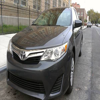

In [ ]:
train_test_valid_dataset['train'][12]['image']

In [ ]:
data = train_test_valid_dataset

## 3. Model Load and Augmentations

In [ ]:

from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(cfg["model_checkpoint"])
feature_extractor

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [ ]:
import cv2
import albumentations as A
import numpy as np

size = feature_extractor.size

train_transforms = A.Compose([
    A.Resize(height=size, width=size),
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
])

val_transforms = A.Compose([
    A.Resize(height=size, width=size),
    A.Normalize(),
])

def preprocess_train(examples):
    examples["pixel_values"] = [
        train_transforms(image=np.array(image))["image"] for image in examples["image"]
    ]

    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [
        val_transforms(image=np.array(image))["image"] for image in examples["image"]
    ]

    return examples

In [ ]:

            # ShiftScaleRotate(p=0.5),
            # HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            # RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
            # CoarseDropout(p=0.5),
            # Cutout(p=0.5)


In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

In [ ]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 214812
})

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=100x100 at 0x7F6AE19A4450>,
 'label': 151,
 'pixel_values': array([[[ 0.79330415,  1.0980392 ,  1.297952  ],
         [ 0.6049319 ,  0.8879551 ,  1.0888017 ],
         [ 0.12543876,  0.3627451 ,  0.5484967 ],
         ...,
         [-1.8610326 , -1.7205881 , -1.3338561 ],
         [-1.8610326 , -1.7205881 , -1.3338561 ],
         [-1.8610326 , -1.7205881 , -1.3338561 ]],
 
        [[ 0.69055563,  0.99299717,  1.1933769 ],
         [ 0.5193081 ,  0.80042017,  1.0016558 ],
         [ 0.07406451,  0.3102241 ,  0.5136384 ],
         ...,
         [-1.8610326 , -1.7205881 , -1.3338561 ],
         [-1.8610326 , -1.7205881 , -1.3338561 ],
         [-1.8610326 , -1.7205881 , -1.3338561 ]],
 
        [[ 0.38231006,  0.6953781 ,  0.91450983],
         [ 0.2624368 ,  0.5553221 ,  0.75764704],
         [-0.04580877,  0.17016807,  0.391634  ],
         ...,
         [-1.8781574 , -1.7380952 , -1.3512853 ],
         [-1.8610326 , -1.7205

## 4. Function and Metric Preparation

In [ ]:
data["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=100x100 at 0x7F6AE19A9310>,
 'label': 151,
 'pixel_values': array([[[-0.06293352, -0.05742294, -0.11381261],
         [-0.08005828, -0.07492995, -0.11381261],
         [-0.11430778, -0.12745096, -0.1312418 ],
         ...,
         [-0.6965494 , -0.495098  , -0.02666664],
         [-0.78217316, -0.617647  , -0.23581697],
         [-0.8164227 , -0.670168  , -0.32296294]],
 
        [[-0.06293352, -0.05742294, -0.11381261],
         [-0.08005828, -0.07492995, -0.11381261],
         [-0.09718303, -0.10994395, -0.1312418 ],
         ...,
         [-0.7136741 , -0.53011197, -0.04409584],
         [-0.78217316, -0.617647  , -0.23581697],
         [-0.8164227 , -0.652661  , -0.30553374]],
 
        [[-0.06293352, -0.05742294, -0.1312418 ],
         [-0.06293352, -0.05742294, -0.11381261],
         [-0.04580877, -0.05742294, -0.09638342],
         ...,
         [-0.7992979 , -0.60014   , -0.09638342],
         [-0.78217316, -0.6001

In [ ]:
np.array(data["train"][0]["image"]).shape

(100, 100, 3)

In [ ]:
import torch
from PIL import Image 

def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        # image.convert("RGB")
        image = example["pixel_values"]
        image = np.array(image)
        # #image = im.fromarray(image).convert("RGB")
        # image = Image.fromarray(np.uint8(image)).convert('RGB')
        # image = np.array(image)
        image = np.moveaxis(image, source=-1, destination=0)

        image = torch.from_numpy(image)
        #image = torch.tensor(image)
        images.append(image)

        labels.append(example["label"])
        
    pixel_values = torch.stack(images)#.float()
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 214812
})

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")
metric1 = load_metric("precision")
metric2 = load_metric("recall")
metric3 = load_metric("f1")
#metric4 = load_metric("roc_auc","multilabel")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def compute_metrics(eval_pred):
    
    
    #logits, labels = eval_pred
    predictions = np.argmax(eval_pred.predictions, axis=1) #-1

    acc = metric.compute(predictions=predictions, references=eval_pred.label_ids)["accuracy"]
    precision = metric1.compute(predictions=predictions, references=eval_pred.label_ids,average="weighted")["precision"]
    recall = metric2.compute(predictions=predictions, references=eval_pred.label_ids,average="weighted")["recall"]
    f1 = metric3.compute(predictions=predictions, references=eval_pred.label_ids,average="weighted")["f1"]
    #roc_auc = metric4.compute(prediction_scores=eval_pred.predictions, references=eval_pred.label_ids,average="weighted")["roc_auc"]
    return {"accuracy":acc,"precision": precision, "recall": recall,"f1":f1}#,"roc_auc":roc_auc}

In [ ]:
# def compute_metrics(eval_pred):
#     """Computes accuracy on a batch of predictions"""
#     predictions = np.argmax(eval_pred.predictions, axis=1)
#     return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'acura_legend'

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForImageClassification.from_pretrained(
    cfg["model_checkpoint"], 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you'd like to fine-tune an already fine-tuned checkpoint
)

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at aaraki/vit-base-patch16-224-in21k-finetuned-cifar10 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([10, 768]) in the checkpoint and torch.Size([375, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([10]) in the checkpoint and torch.Size([375]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4.5. Login to HF and WANDB(PLEASE OPEN)

In [ ]:
import wandb
import os

os.environ['WANDB_NOTEBOOK_NAME'] = 'vit_hf_wand'

In [ ]:
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find vit_hf_wand.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## 5. Model Execution

In [ ]:
model_name = cfg["model_checkpoint"].split("/")[-1]

training_args = TrainingArguments(
    f"{model_name}_album_vit"+"VMMRdb_make_model_album_pred",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=cfg["learning_rate"],
    per_device_train_batch_size=cfg["batch_size"],
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=cfg["batch_size"],
    num_train_epochs=cfg["epochs"],
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="all",#todo

    #output_dir="./output",
)

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:729: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  FutureWarning,
Cloning https://huggingface.co/venetis/vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred into local empty directory.


In [ ]:
run = wandb.init(project="brand_model_vit_hf", reinit="True", config=training_args)

wandb: Currently logged in as: venetispall. Use `wandb login --relogin` to force relogin


In [ ]:
train_results = trainer.train()


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 214812
  Num Epochs = 15
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 4
  Total optimization steps = 12585
  Number of trainable parameters = 86087031
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,4.611200,4.561534,0.142485,0.083661,0.142485,0.064573
1,3.117700,2.959501,0.424028,0.342379,0.424028,0.328343
2,2.079300,2.004783,0.577126,0.508139,0.577126,0.502949
3,1.456600,1.455448,0.676039,0.633264,0.676039,0.628036
4,1.130700,1.131863,0.734992,0.702705,0.734992,0.701304
5,0.936700,0.932761,0.773760,0.754636,0.773760,0.750349
6,0.778300,0.802449,0.798637,0.789333,0.798637,0.781852
7,0.602200,0.718724,0.817444,0.809781,0.817444,0.805480
8,0.523400,0.663476,0.831335,0.822033,0.831335,0.821656
9,0.429800,0.618191,0.838820,0.833693,0.838820,0.830180


***** Running Evaluation *****
  Num examples = 26852
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/checkpoint-839
Configuration saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/checkpoint-839/config.json
Model weights saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/checkpoint-839/pytorch_model.bin
Feature extractor saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/checkpoint-839/preprocessor_config.json
Feature extractor saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVM

In [ ]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred
Configuration saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/config.json
Model weights saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/pytorch_model.bin
Feature extractor saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/preprocessor_config.json
Saving model checkpoint to vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred
Configuration saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/config.json
Model weights saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/pytorch_model.bin
Feature extractor saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/preprocessor_config.json
Several commits (2) will b

Upload file pytorch_model.bin:   0%|          | 3.34k/328M [00:00<?, ?B/s]

Upload file runs/Nov27_16-45-31_d56b08e6258b/events.out.tfevents.1669567543.d56b08e6258b.107.0:   1%|1        …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/venetis/vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred
   4859711..c0cc9cb  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/venetis/vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred
   4859711..c0cc9cb  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Image Classification', 'type': 'image-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.8572173394905408}, {'name': 'Precision', 'type': 'precision', 'value': 0.852456407193856}, {'name': 'Recall', 'type': 'recall', 'value': 0.8572173394905408}, {'name': 'F1', 'type': 'f1', 'value': 0.851856949816946}]}
To https://huggingface.co/venetis/vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred
   

***** train metrics *****
  epoch                    =           15.0
  total_flos               = 233320245948GF
  train_loss               =         1.2989
  train_runtime            =     9:29:30.36
  train_samples_per_second =         94.297
  train_steps_per_second   =          0.368


In [ ]:
metrics = trainer.evaluate(train_ds)

In [ ]:
#keys produced by evaluate always have the prefix of eval
#which means that they will overwrite each other when uploaded in wandb
# name_dict = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

for k, v in metrics.items(): 
  #last one is epoch skip
  if k=="epoch":
    continue

  new_key = "train_" + k.split("_")[1]
  if k.split("_")[1]=="steps" or k.split("_")[1]=="samples":
    new_key = new_key + "_per_second"
  metrics[new_key] = metrics.pop(k)


In [ ]:
trainer.log_metrics("train_more", metrics)
trainer.save_metrics("train_more", metrics)
trainer.save_state()

In [ ]:
wandb.log(metrics)

In [ ]:
metrics = trainer.evaluate(val_ds)
trainer.log_metrics("valid", metrics)
trainer.save_metrics("valid", metrics)
trainer.save_state()

***** Running Evaluation *****
  Num examples = 26852
  Batch size = 64


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** valid metrics *****
  epoch                   =       15.0
  eval_accuracy           =     0.8572
  eval_f1                 =     0.8519
  eval_loss               =     0.5489
  eval_precision          =     0.8525
  eval_recall             =     0.8572
  eval_runtime            = 0:02:11.97
  eval_samples_per_second =    203.462
  eval_steps_per_second   =      3.182


In [ ]:
wandb.log(metrics)

In [ ]:
metrics = trainer.evaluate(test_ds)

In [ ]:
#keys produced by evaluate always have the prefix of eval
#which means that they will overwrite each other when uploaded in wandb
# name_dict = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

for k, v in metrics.items(): 
  #last one is epoch skip
  if k=="epoch":
    continue

  new_key = "test_" + k.split("_")[1]
  if k.split("_")[1]=="steps" or k.split("_")[1]=="samples":
    new_key = new_key + "_per_second"
  metrics[new_key] = metrics.pop(k)

In [ ]:
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)
trainer.save_state()

In [ ]:
wandb.log(metrics)

In [ ]:
# #log test accuracy and loss
# wandb.log({"test_loss": los, 
#            "test_acc": acc ,
#           })

In [ ]:
# outputs = trainer.predict(val_ds)

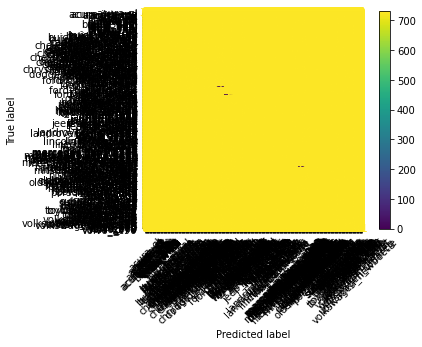

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_true = outputs.label_ids
# y_pred = outputs.predictions.argmax(1)

# labels = train_ds.features['label'].names
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(xticks_rotation=45)

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred
Configuration saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/config.json
Model weights saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/pytorch_model.bin
Feature extractor saved in vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/preprocessor_config.json


Upload file runs/Nov27_16-45-31_d56b08e6258b/events.out.tfevents.1669603131.d56b08e6258b.107.2: 100%|#########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/venetis/vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred
   ee7fdcf..1e1f666  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/venetis/vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred
   ee7fdcf..1e1f666  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Image Classification', 'type': 'image-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.8594145687472069}, {'name': 'Precision', 'type': 'precision', 'value': 0.8556226344856697}, {'name': 'Recall', 'type': 'recall', 'value': 0.8594145687472069}, {'name': 'F1', 'type': 'f1', 'value': 0.8544117041750896}]}
To https://huggingface.co/venetis/vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred
 

'https://huggingface.co/venetis/vit-base-patch16-224-in21k-finetuned-cifar10_album_vitVMMRdb_make_model_album_pred/commit/1e1f6660b2f79ab5d3251fed7d54510f2f5a47ee'

In [ ]:
# # Save the model, save it to wandb server
# wandb.save('model.pt')
#wandb.save(f"{model_name}_album_vit"+"VMMRdb_make_model_album_pred.pt")

In [ ]:
run.finish()

epoch,▁▁▁
eval/accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇
eval/f1,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇
eval/loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
eval/precision,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇█▇▇
eval/recall,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
eval/samples_per_second,▇▇▇▇▇▆▆▆▅▅▄▄▃▂▅▁██
eval/steps_per_second,▇▇▇▇▇▆▆▆▅▅▄▄▃▂▅▁██
eval_accuracy,▁
eval_f1,▁
